In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


### Task 1 - Problem Analysis and Data Preprocess

In [2]:
base_path = r'.'
files = ['accessories.csv', 'bags.csv', 'beauty.csv', 'house.csv', 
         'jewelry.csv', 'kids.csv', 'men.csv', 'shoes.csv', 'women.csv']

data_frames = {file.split('.')[0]: pd.read_csv(os.path.join(base_path, file)) for file in files}

# Access the DataFrames
data_frame_accessories = data_frames['accessories']
data_frame_bags = data_frames['bags']
data_frame_beauty = data_frames['beauty']
data_frame_house = data_frames['house']
data_frame_jewelry = data_frames['jewelry']
data_frame_kids = data_frames['kids']
data_frame_men = data_frames['men']
data_frame_shoes = data_frames['shoes']
data_frame_women = data_frames['women']

In [5]:
df = pd.concat(data_frames.values(), ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74999 entries, 0 to 74998
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               74999 non-null  object 
 1   subcategory            74999 non-null  object 
 2   name                   74999 non-null  object 
 3   current_price          74999 non-null  float64
 4   raw_price              74999 non-null  float64
 5   currency               74999 non-null  object 
 6   discount               74999 non-null  int64  
 7   likes_count            74999 non-null  int64  
 8   is_new                 74999 non-null  bool   
 9   brand                  14161 non-null  object 
 10  brand_url              10340 non-null  object 
 11  codCountry             65889 non-null  object 
 12  variation_0_color      63215 non-null  object 
 13  variation_1_color      52652 non-null  object 
 14  variation_0_thumbnail  63215 non-null  object 
 15  va

####  Pre-process Dataframe

In [6]:
chosen_columns = {'category', 'name', 'current_price', 'raw_price', 'likes_count', 'discount', 'is_new'}
df = df.loc[:, df.columns.intersection(chosen_columns)]

In [7]:
# Define a dictionary with the columns as keys and their fill values as values
fill_values = {
    'likes_count': 0,
    'discount': 0,
    'current_price': df['current_price'].median()
}

# Use a loop to fill missing values for each specified column without using inplace
for column, value in fill_values.items():
    df[column] = df[column].fillna(value)

In [8]:
df = df[df['likes_count'] > 50]

#### Hypothesis 1: Price and Likes Count

**Question**: Is there a significant correlation between the `current_price` and the `likes_count` of products?

- **Null Hypothesis (H0)**: There is no significant correlation between `current_price` and `likes_count`. (Correlation coefficient = 0)
- **Alternative Hypothesis (HA or H1)**: There is a significant correlation between `current_price` and `likes_count`. (Correlation coefficient ≠ 0)

In [9]:
# Calculate Pearson correlation coefficient
correlation = df['current_price'].corr(df['likes_count'])
print("Pearson Correlation Coefficient:", correlation)

Pearson Correlation Coefficient: 0.035926964328265344


In [13]:
import scipy.stats as stats

# Perform Pearson correlation test
correlation, p_value = stats.pearsonr(df['current_price'], df['likes_count'])
print("Pearson Correlation Coefficient:", correlation)
print("P-value:", p_value)


alpha = 0.05

# Decision based on p-value
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between current_price and likes_count.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between current_price and likes_count.")

Pearson Correlation Coefficient: 0.035926964328265386
P-value: 2.564527505355469e-14
Reject the null hypothesis: There is a significant correlation between current_price and likes_count.


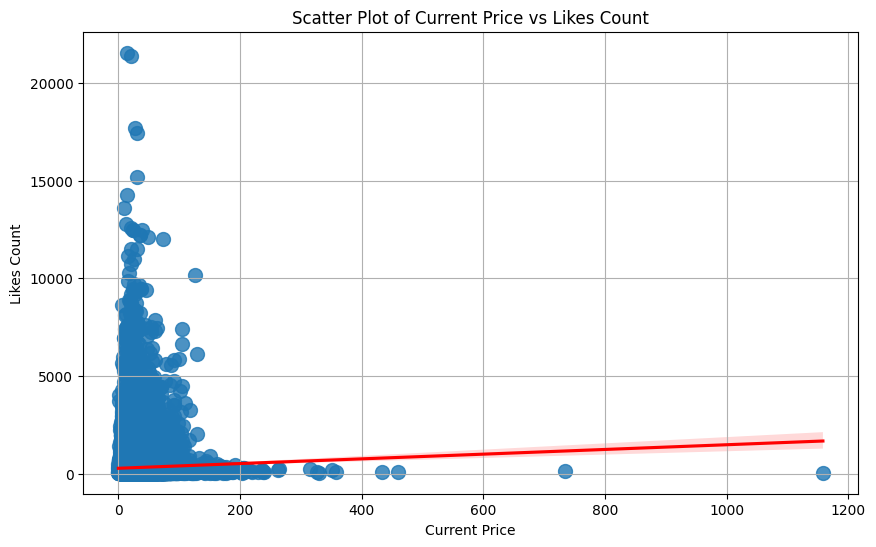

In [15]:
# Plotting with Seaborn
plt.figure(figsize=(10, 6))

# Scatter plot with regression line
sns.regplot(x='current_price', y='likes_count', data=df, scatter_kws={'s':100}, line_kws={'color':'red'})
plt.title('Scatter Plot of Current Price vs Likes Count')
plt.xlabel('Current Price')
plt.ylabel('Likes Count')
plt.grid(True)
plt.show()

#### Hypothesis 2: Discount and Likes Count

**Question**: Does the `discount` offered on a product affect the `likes_count`?

- **Null Hypothesis (H0)**: There is no significant correlation between `discount` and `likes_count`. (Correlation coefficient = 0)
- **Alternative Hypothesis (HA or H1)**: There is a significant correlation between `discount` and `likes_count`. (Correlation coefficient ≠ 0)

In [ ]:
## TODO

#### Hypothesis 3: Comparison of Likes Count Across Categories

**Question**: Is the average `likes_count` different across product categories?

- **Null Hypothesis (H0)**: The average `likes_count` is the same across all product categories.
- **Alternative Hypothesis (HA or H1)**: The average `likes_count` differs across at least one product category.

In [ ]:
## TODO


#### Hypothesis 4: Price Influence on Discount

**Question**: Does the `current_price` of a product influence the `discount` applied?

- **Null Hypothesis (H0)**: There is no significant correlation between `current_price` and `discount`. (Correlation coefficient = 0)
- **Alternative Hypothesis (HA or H1)**: There is a significant correlation between `current_price` and `discount`. (Correlation coefficient ≠ 0)

In [ ]:
## TODO

<!-- #### Hypothesis 5: Comparing Mean Likes Count Across Categories


Null Hypothesis (H0): All group means are equal (no significant difference between groups).
Alternative Hypothesis (HA): At least one group mean is different from the others. -->

#### Premium Categories and Best 7 Categories


In [18]:

# Calculate average price per category and sort in descending order
def get_top_categories_by_price(df, top_n=7):
    avg_price_per_category = df.groupby('category')['current_price'].mean().sort_values(ascending=False)
    top_categories = avg_price_per_category.head(top_n).index.tolist()
    return top_categories

# Filter dataset to include only the top categories
def filter_top_categories(df, top_categories):
    return df[df['category'].isin(top_categories)]

# Find the top N products based on multiple criteria
def get_top_products(df, top_n=10):
    return df.sort_values(
        by=['likes_count', 'current_price', 'discount', 'is_new'], 
        ascending=[False, False, False, False]
    ).head(top_n)


    # Get top 7 categories based on average current price
top_categories = get_top_categories_by_price(df, top_n=7)
    
# Filter the dataset to include only products from the top 7 categories
filtered_df = filter_top_categories(df, top_categories)
    
# Find the top 10 products in these categories
top_products = get_top_products(filtered_df, top_n=10)
    
# Output results
print("Top 7 Categories (based on average price):", top_categories)

Top 7 Categories (based on average price): ['shoes', 'men', 'bags', 'women', 'kids', 'beauty', 'house']


In [19]:
print("Top 10 Products in the Top 7 Categories:\n", top_products)

Top 10 Products in the Top 7 Categories:
       category                                               name  \
55676    shoes  Chaussures Plats Décontractées En Suède Mocass...   
70482    women               Blouse Large Couleur Pure pour Femme   
70457    women                   Robe Longue avec Boutons Chinois   
63939    women  Gracila Femme Maxi Robe Irrégulier Vêtement Vi...   
56378    shoes  Chaussures De Grande Taille Semelle Souple À E...   
60200    women  Soutien-gorge Sexy à Décollecté Plongeant sans...   
50188    shoes               Bottines Plates Doublées de Fourrure   
63442    women  Soutien-gorge Sexy Antichoc Sans Armature Ling...   
54981    shoes  SOCOFY Sandales Confortables Plates Avec Bride...   
74381    women        Manteau imprimé floral à feuilles à capuche   

       current_price  raw_price  discount  likes_count  is_new  
55676          14.99      54.95        73        21547   False  
70482          19.99      56.99        65        21403   False  
704

### Task 2 - Clustering

### Task 3: Classification 